In [2]:
# download.py

import os
import sys
import urllib3
from urllib.parse import urlparse
import pandas as pd
import itertools
import shutil

from urllib3.util import Retry

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

classes = ["cat", "fish"]
set_types = ["train", "test", "val"]

def download_image(url, klass, data_type):
    basename = os.path.basename(urlparse(url).path)
    filename = "{}/{}/{}".format(data_type, klass, basename)
    if not os.path.exists(filename):
        try: 
            http = urllib3.PoolManager(retries=Retry(connect=1, read=1, redirect=2))
            with http.request("GET", url, preload_content=False) as resp, open(
                filename, "wb"
            ) as out_file:
                if resp.status == 200:
                    shutil.copyfileobj(resp, out_file)
                else:
                    print("Error downloading {}".format(url))
            resp.release_conn()
        except:
            print("Error downloading {}".format(url))


if __name__ == "__main__":
    if not os.path.exists("images.csv"):
        print("Error: can't find images.csv!")
        sys.exit(0)

    # get args and create output directory
    imagesDF = pd.read_csv("images.csv")

    for set_type, klass in list(itertools.product(set_types, classes)):
        path = "./{}/{}".format(set_type, klass)
        if not os.path.exists(path):
            print("Creating directory {}".format(path))
            os.makedirs(path)

    print("Downloading {} images".format(len(imagesDF)))

    result = [
        download_image(url, klass, data_type)
        for url, klass, data_type in zip(
            imagesDF["url"], imagesDF["class"], imagesDF["type"]
        )
    ]
    sys.exit(0)

Creating directory ./train/cat
Creating directory ./train/fish
Creating directory ./test/cat
Creating directory ./test/fish
Creating directory ./val/cat
Creating directory ./val/fish
Error downloading http://farm1.static.flickr.com/1/1004525_cba96ba3c3.jpg
Error downloading http://farm1.static.flickr.com/33/65048097_e5264bf855.jpg
Error downloading http://farm3.static.flickr.com/2354/2102976081_61c8614be8.jpg
Error downloading http://farm2.static.flickr.com/1390/709949156_5e4ac3f499.jpg
Error downloading http://farm2.static.flickr.com/1221/1011749126_44a195db4c.jpg
Error downloading http://farm1.static.flickr.com/173/416994740_6ada308baa.jpg
Error downloading http://farm1.static.flickr.com/3/4193130_a058cdb81f.jpg
Error downloading http://farm1.static.flickr.com/1/1004528_a111209743.jpg
Error downloading http://farm1.static.flickr.com/223/522289072_13b4f92d39.jpg
Error downloading http://farm1.static.flickr.com/28/100739452_5be2c11557.jpg
Error downloading http://farm1.static.flickr.co

SystemExit: 0

C:\Users\Omer\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# DataLoaders

In [1]:
# Labeling and normalizing from directories like imagegenerator on tensorflow
import torchvision
import torch
from torchvision import transforms

transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [2]:
train_data_path = "./train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=transforms)

val_data_path = "./val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=transforms)

test_data_path = "./test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=transforms)

In [3]:
from torch.utils import data
batch_size=64
train_data_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader = data.DataLoader(val_data, batch_size=batch_size)
test_data_loader = data.DataLoader(test_data, batch_size=batch_size)

# Simple Neural Network

In [4]:
from torch import nn
import torch.nn.functional as F

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(12288, 84) # 3*64*64 = 12288 (3 color channel, 64x64 pixels)
        self.fc2 = nn.Linear(84, 50) # Linear is equal to Dense on Keras.
        self.fc3 = nn.Linear(50,2) # we have two classes.
        
    def forward(self, x):
        x = x.view(-1, 12288)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # As we are using cross entropy loss, there is no need to use softmax. I tried to add softmax on this row but after that my model didn't converge.
        return x
    
simplenet = SimpleNet()

### Changing device to Cuda GPU
import torch

if torch.cuda.is_available():

    device = torch.device("cuda")
    
    print("cuda")
    
else:

    device = torch.device("cpu")
    
    print("cpu")
    
simplenet.to(device)


In [5]:
# Adam optimizer
import torch.optim as optim
optimizer = optim.Adam(simplenet.parameters(), lr=0.001)

# Training Block

In [6]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()   # training mode
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()   # evaluation mode for test.
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets)
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)
        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss, valid_loss, num_correct / num_examples))

In [7]:
train(simplenet, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader)

Epoch: 0, Training Loss: 0.68, Validation Loss: 0.53, accuracy = 0.75
Epoch: 1, Training Loss: 0.42, Validation Loss: 0.45, accuracy = 0.82
Epoch: 2, Training Loss: 0.30, Validation Loss: 0.47, accuracy = 0.83
Epoch: 3, Training Loss: 0.21, Validation Loss: 0.54, accuracy = 0.79
Epoch: 4, Training Loss: 0.15, Validation Loss: 0.63, accuracy = 0.74
Epoch: 5, Training Loss: 0.10, Validation Loss: 0.63, accuracy = 0.75
Epoch: 6, Training Loss: 0.07, Validation Loss: 0.59, accuracy = 0.78
Epoch: 7, Training Loss: 0.05, Validation Loss: 0.60, accuracy = 0.78
Epoch: 8, Training Loss: 0.03, Validation Loss: 0.81, accuracy = 0.73
Epoch: 9, Training Loss: 0.03, Validation Loss: 0.77, accuracy = 0.75
Epoch: 10, Training Loss: 0.02, Validation Loss: 0.84, accuracy = 0.70
Epoch: 11, Training Loss: 0.01, Validation Loss: 0.80, accuracy = 0.72
Epoch: 12, Training Loss: 0.01, Validation Loss: 0.81, accuracy = 0.75
Epoch: 13, Training Loss: 0.01, Validation Loss: 0.77, accuracy = 0.78
Epoch: 14, Train

# Making Predictions

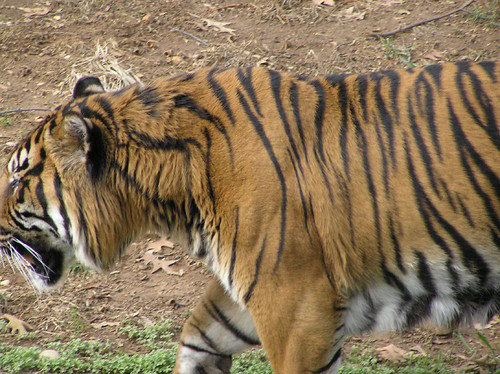

torch.Size([3, 64, 64])
torch.Size([1, 3, 64, 64])
cat


In [8]:
from PIL import Image
from IPython.display import display
labels = ['cat','fish']
path = "./test/cat/100970828_a2e6ade482.jpg"
img = Image.open(path)
display(img)
img = transforms(img)
print(img.size())
img = img.unsqueeze(0) # reshapeing input from 3*64*64 to 1*3*64*64
print(img.size())
prediction = simplenet(img)
prediction = prediction.argmax()

print(labels[prediction])

In [10]:
corrects = 0
total = 0
for batch in test_data_loader:
    inputs, targets = batch
    prediction = simplenet(img)
    correct = torch.eq(torch.max(F.softmax(prediction, dim=1), dim=1)[1], targets).view(-1)
    correct_num = torch.sum(correct)
    total_instance = correct.size()[0]
    corrects += correct_num.item()
    total += total_instance
print("Model accuracy on test data: {}%".format(round(corrects/total*100,2)))

Model accuracy on test data: 56.79%


# Model Saving and Loading

In [12]:
# With below method, we are saving parameters and the structure of the model.
# torch.save(simplenet, "./simplenet")
# simplenet = torch.load("./simplenet")

In [13]:
# if we change the model's structure, state_dict only loads the layers that we defined before saving.

# saving state_dict
# path = "./simplenet"
# torch.save(simplenet.state_dict(), path)

# loading
# simplenet = SimpleNet()
# simplenet_state_dict = torch.load("./simplenet")
# simplenet.load_state_dict(simplenet_state_dict)

In [14]:
simplenet.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.0007,  0.0062, -0.0038,  ..., -0.0193, -0.0130, -0.0117],
                      [ 0.0138, -0.0022,  0.0041,  ..., -0.0101, -0.0073, -0.0027],
                      [ 0.0033,  0.0050,  0.0079,  ..., -0.0011, -0.0077,  0.0040],
                      ...,
                      [-0.0023, -0.0171, -0.0073,  ..., -0.0057, -0.0028, -0.0085],
                      [-0.0100,  0.0042, -0.0069,  ..., -0.0067,  0.0025,  0.0019],
                      [-0.0200, -0.0038, -0.0091,  ..., -0.0062, -0.0038,  0.0049]])),
             ('fc1.bias',
              tensor([-6.0726e-03,  1.1110e-02, -1.1931e-02,  1.3579e-02, -1.8381e-02,
                      -2.0036e-02, -6.1938e-03, -3.6227e-03, -1.3622e-03,  1.9161e-02,
                      -7.7765e-04, -2.3107e-03,  2.3723e-02, -4.1172e-03,  2.0741e-02,
                       6.1565e-03,  7.8148e-03, -1.4625e-02,  1.1855e-02,  1.7483e-02,
                      -2.2958e-04,  6.8884e-04,  1.8825e-02, -1.